### 2016 Boston Marathon - Modeling 
#### Predicting returns on income from college education and experience - the case of Ecuador’s national scholarship’s program

In [63]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

### I am going to use the merged data
- The merged data has the finishing times for runners who participated in the 2015 Boston Marathon who also participated in the 2016 Marathon.
- The data also has calculations of elevations at each traking point of the race (5_k, 10_k, etc)
- Data has the total number of running of ascending and descending meters accumulated at each point of the race (5_k, 10_k, etc)


## Analysis - breakdown (links)
---
| Analysis - Models  | Name  |
|:---:|---|
| [Correlations](#correlations) | Correlations |
| [Finishing Times 2015 and 2016](#times_2015_2016) | Finishing times 2015 vs 2106 |
| [Predictions](#predictions) | Setting up Predictions |
| [Predictions OLS](#OLS) | Linear Regression |
| [Regularization Ridge](#ridge) | Ridge Regression |
| [Regularization Lasso](#lasso) | Lasso Regression |
| [Regularization Elastic Net](#elasticnet) | Elastic Net Regression |
| [Regression Tree](#regressiontree) | Regression Tree |
| [Random Forest Regression](#randomforest) | Random Forest |
| [Gradient Boosting Regressor](#gradientboosting) | Gradient Boosting Regressor |
| [Ensemble Gradient Boosting Regressor](#ensemblegradient) | Ensemble Gradient Boosting Regressor |
| [Summary of Model's Performance](#modelperformance) | Model's Performance MSE and r^2 |
| [Summary of Model's Performance (predicted vs real values)](#predictedvsactual) | Predicted vs real values |


---

In [64]:
import cPickle
f = open('../clean_data/boston_16_15.save', 'rb')
boston_16_15 = cPickle.load(f)
f.close()

In [65]:
print boston_16_15.shape

(5438, 50)


<a name="correlations"></a>
## Correlations?
---

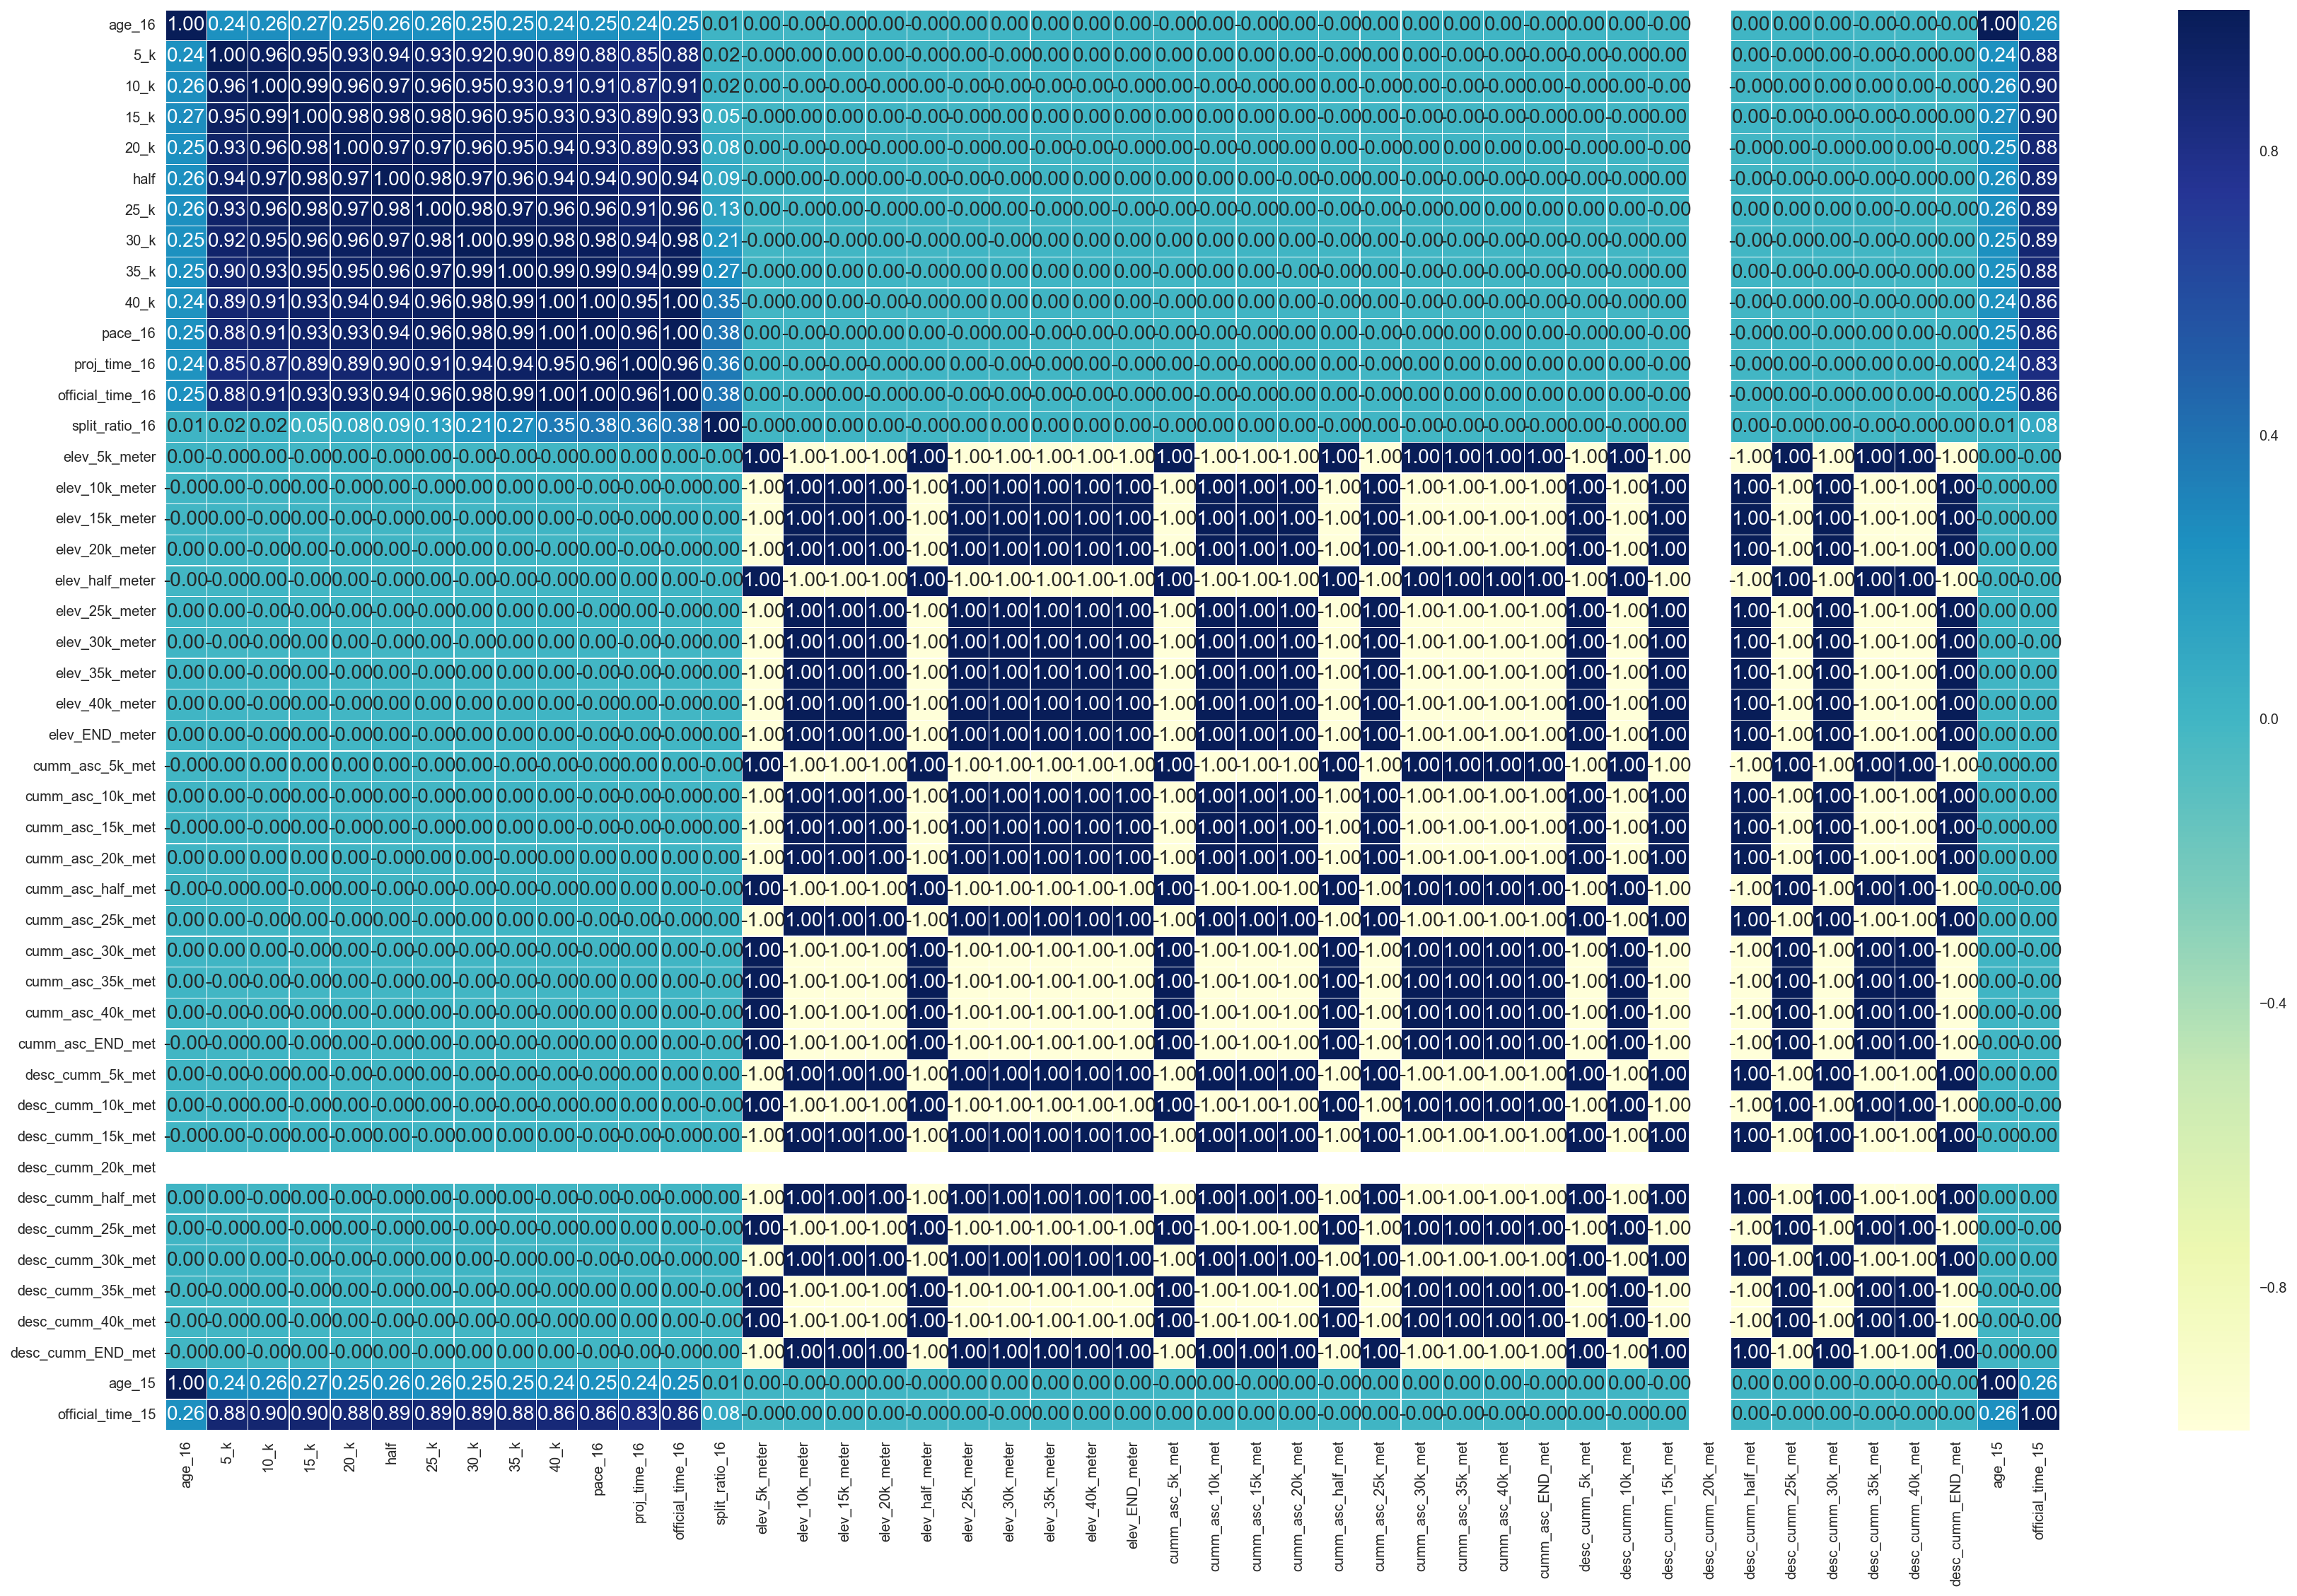

In [66]:
fig = plt.figure(figsize=(30,18))
ax = fig.gca()
sns.heatmap(boston_16_15.corr(), annot=True, linewidths=.20, 
            annot_kws={'size': 14}, cmap="YlGnBu", vmin=-1, vmax=1, fmt='.2f',ax=ax)
plt.show()

- It looks like elevation points (elevation at each tracking time of the race, cummulative ascending and descending) have a negative correlation with the 2016 finishing time.
- On the other hand, runners age in 2015 and official time in 2015 have a positive correlation, where runners age in 2015 is not too strong
- Split ratio of 2016 is positively correlated but is not strong
- We are not seeing gender and /or country of residence so lets create dummies

<a name="times_2015_2016"></a>
## Finishing times 2015 vs 2106 ?
---
- Time (2015) vs Age (2015) by Gender and Country
- Outliers in 2016 time?

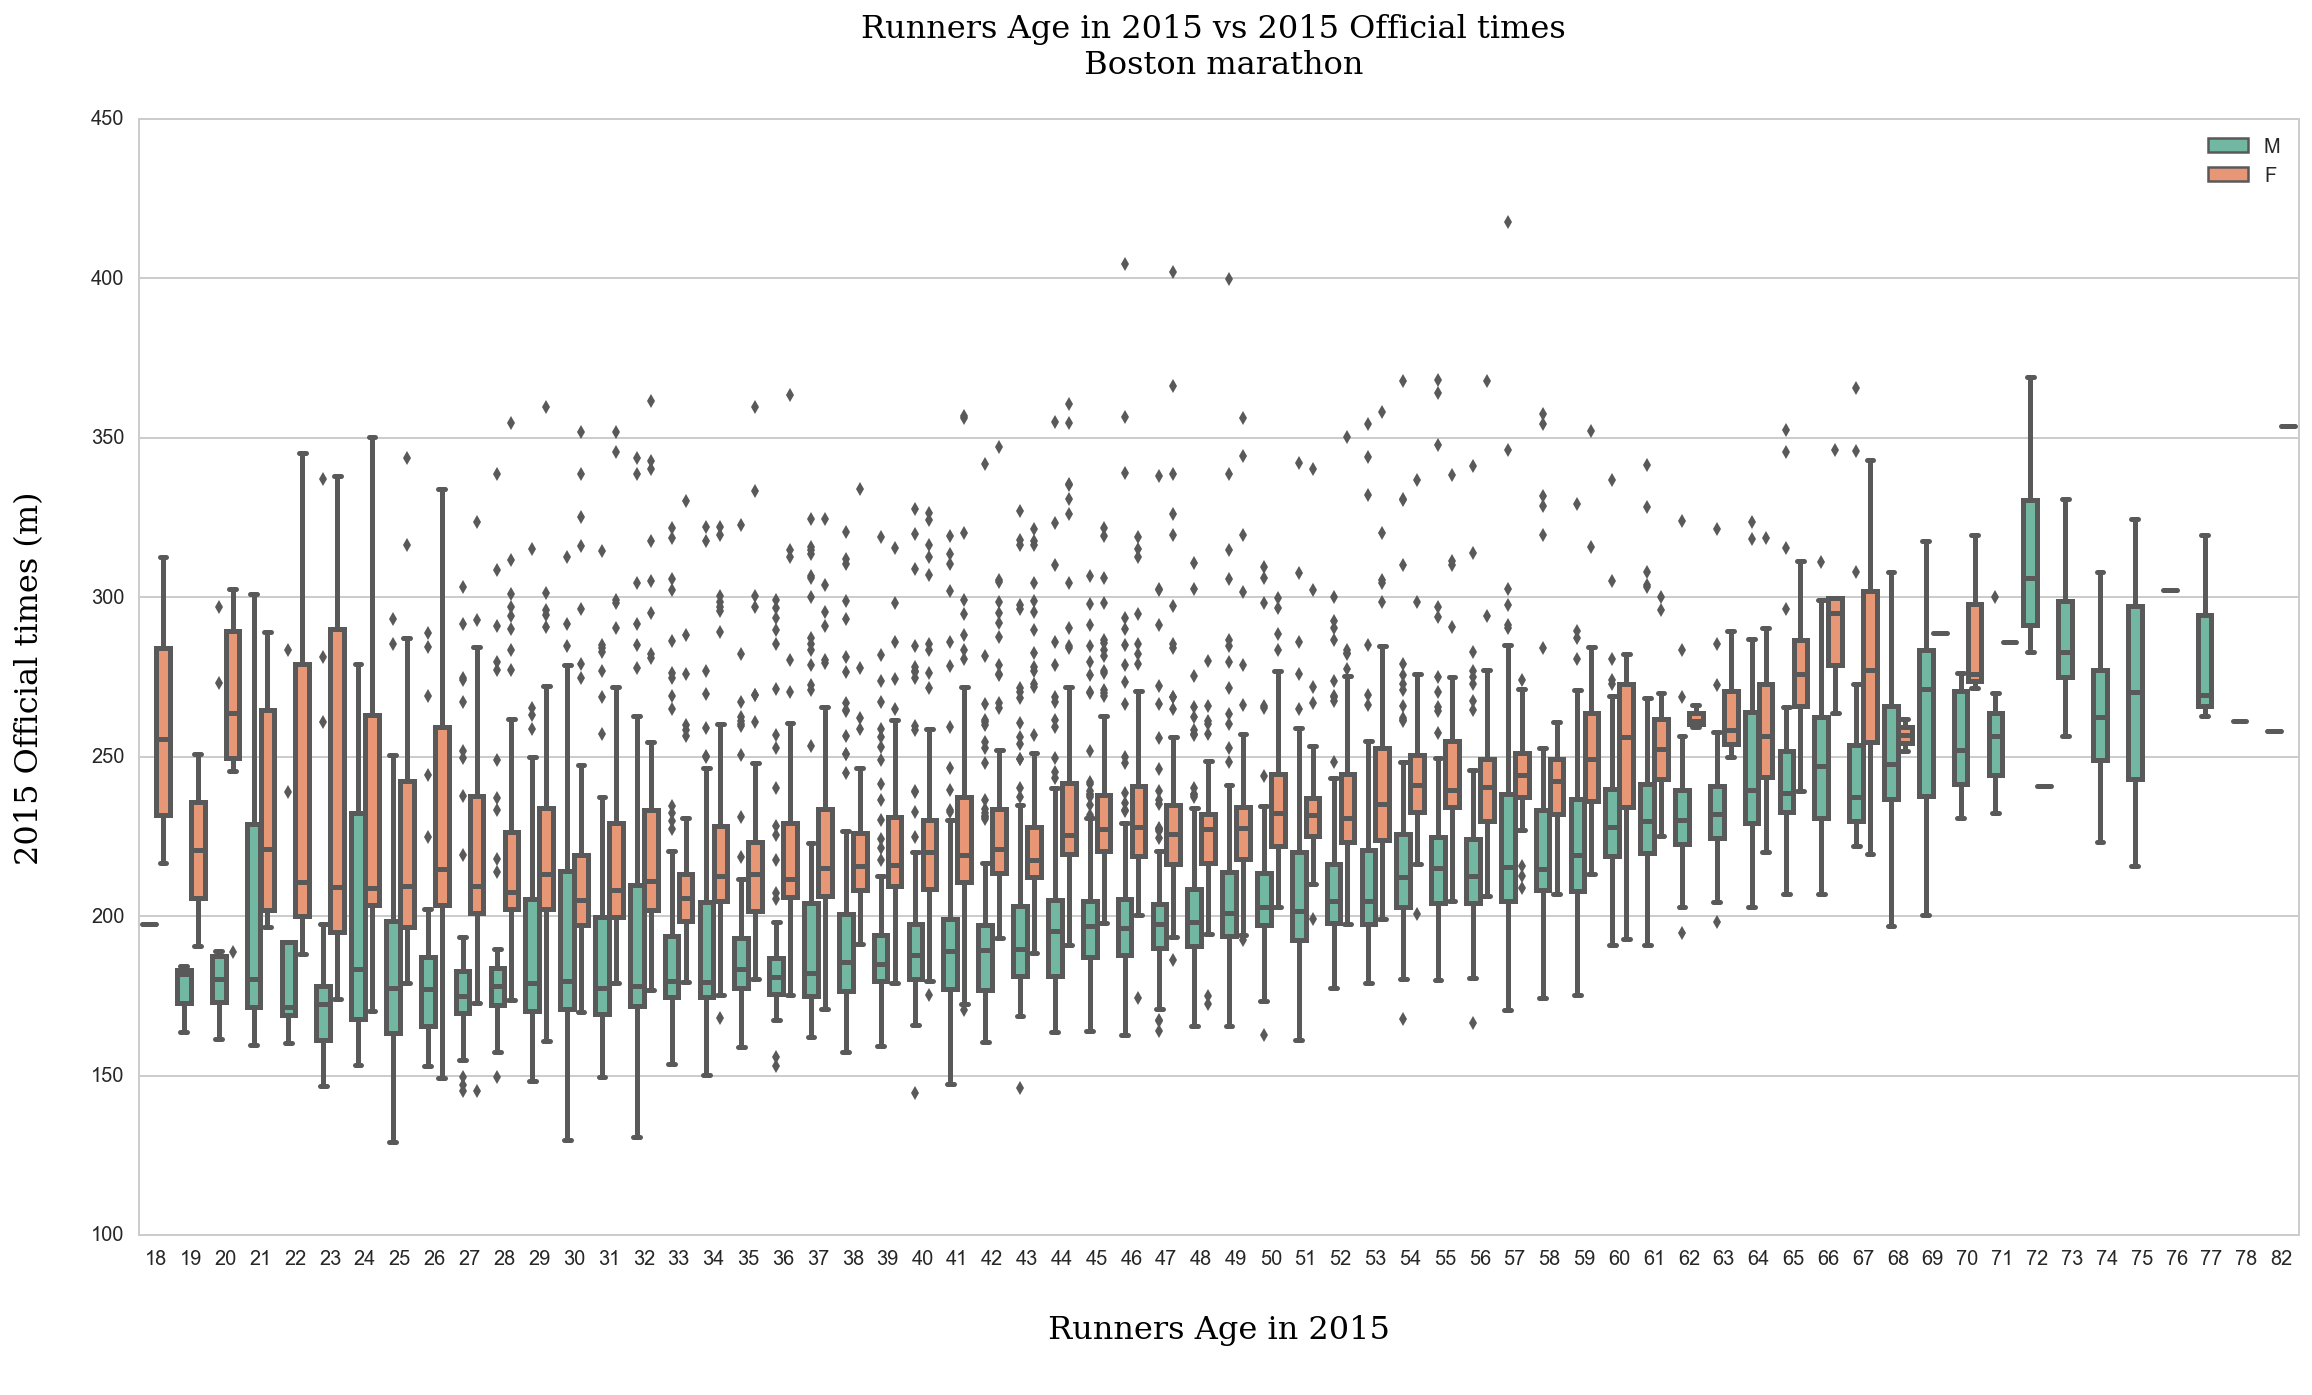

In [67]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
""""""
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
sns.boxplot(x="age_15", y="official_time_15", hue="gender", data=boston_16_15, palette="Set2", ax=ax, linewidth=2.5)

plt.title('Runners Age in 2015 vs 2015 Official times \n Boston marathon\n', fontdict=font)
plt.ylabel('2015 Official times (m)\n', fontdict=font)
plt.xlabel('\n Runners Age in 2015 \n', fontdict=font)
plt.legend(loc='best')

plt.subplots_adjust(left=0.15)
#fig.savefig('../graphs/rank_gender_time.pdf')
plt.show()

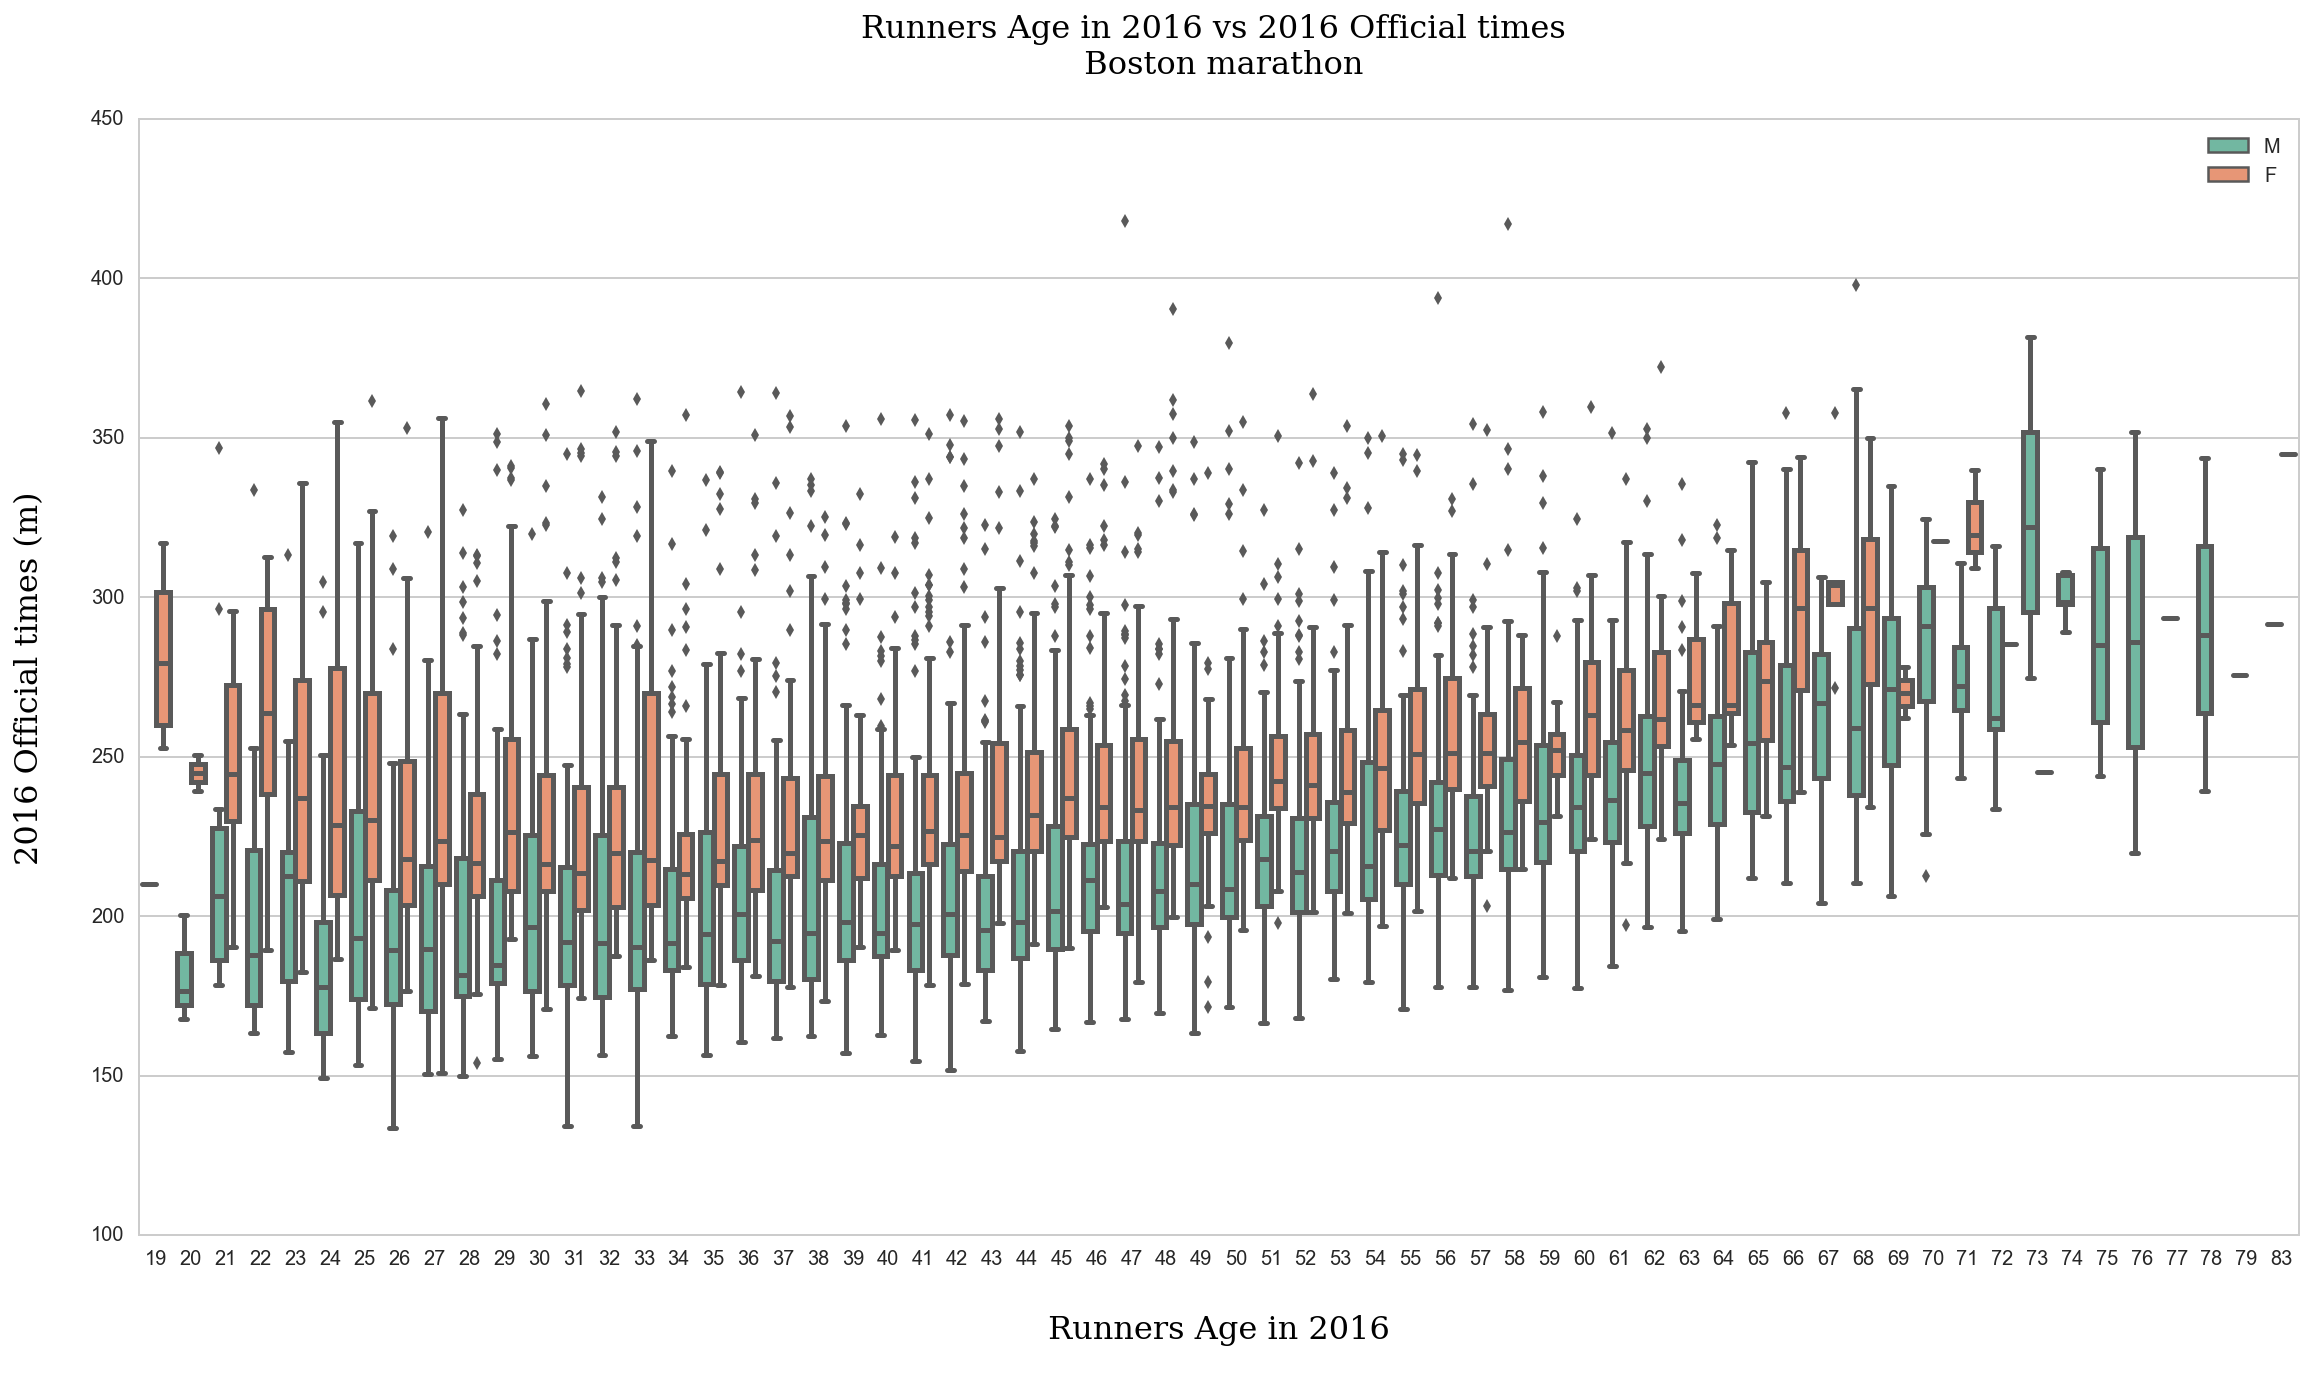

In [68]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
sns.boxplot(x="age_16", y="official_time_16", hue="gender", data=boston_16_15, palette="Set2", ax=ax, linewidth=2.5)

plt.title('Runners Age in 2016 vs 2016 Official times \n Boston marathon\n', fontdict=font)
plt.ylabel('2016 Official times (m)\n', fontdict=font)
plt.xlabel('\n Runners Age in 2016 \n', fontdict=font)
plt.legend(loc='best')

plt.subplots_adjust(left=0.15)
#fig.savefig('../graphs/rank_gender_time.pdf')
plt.show()

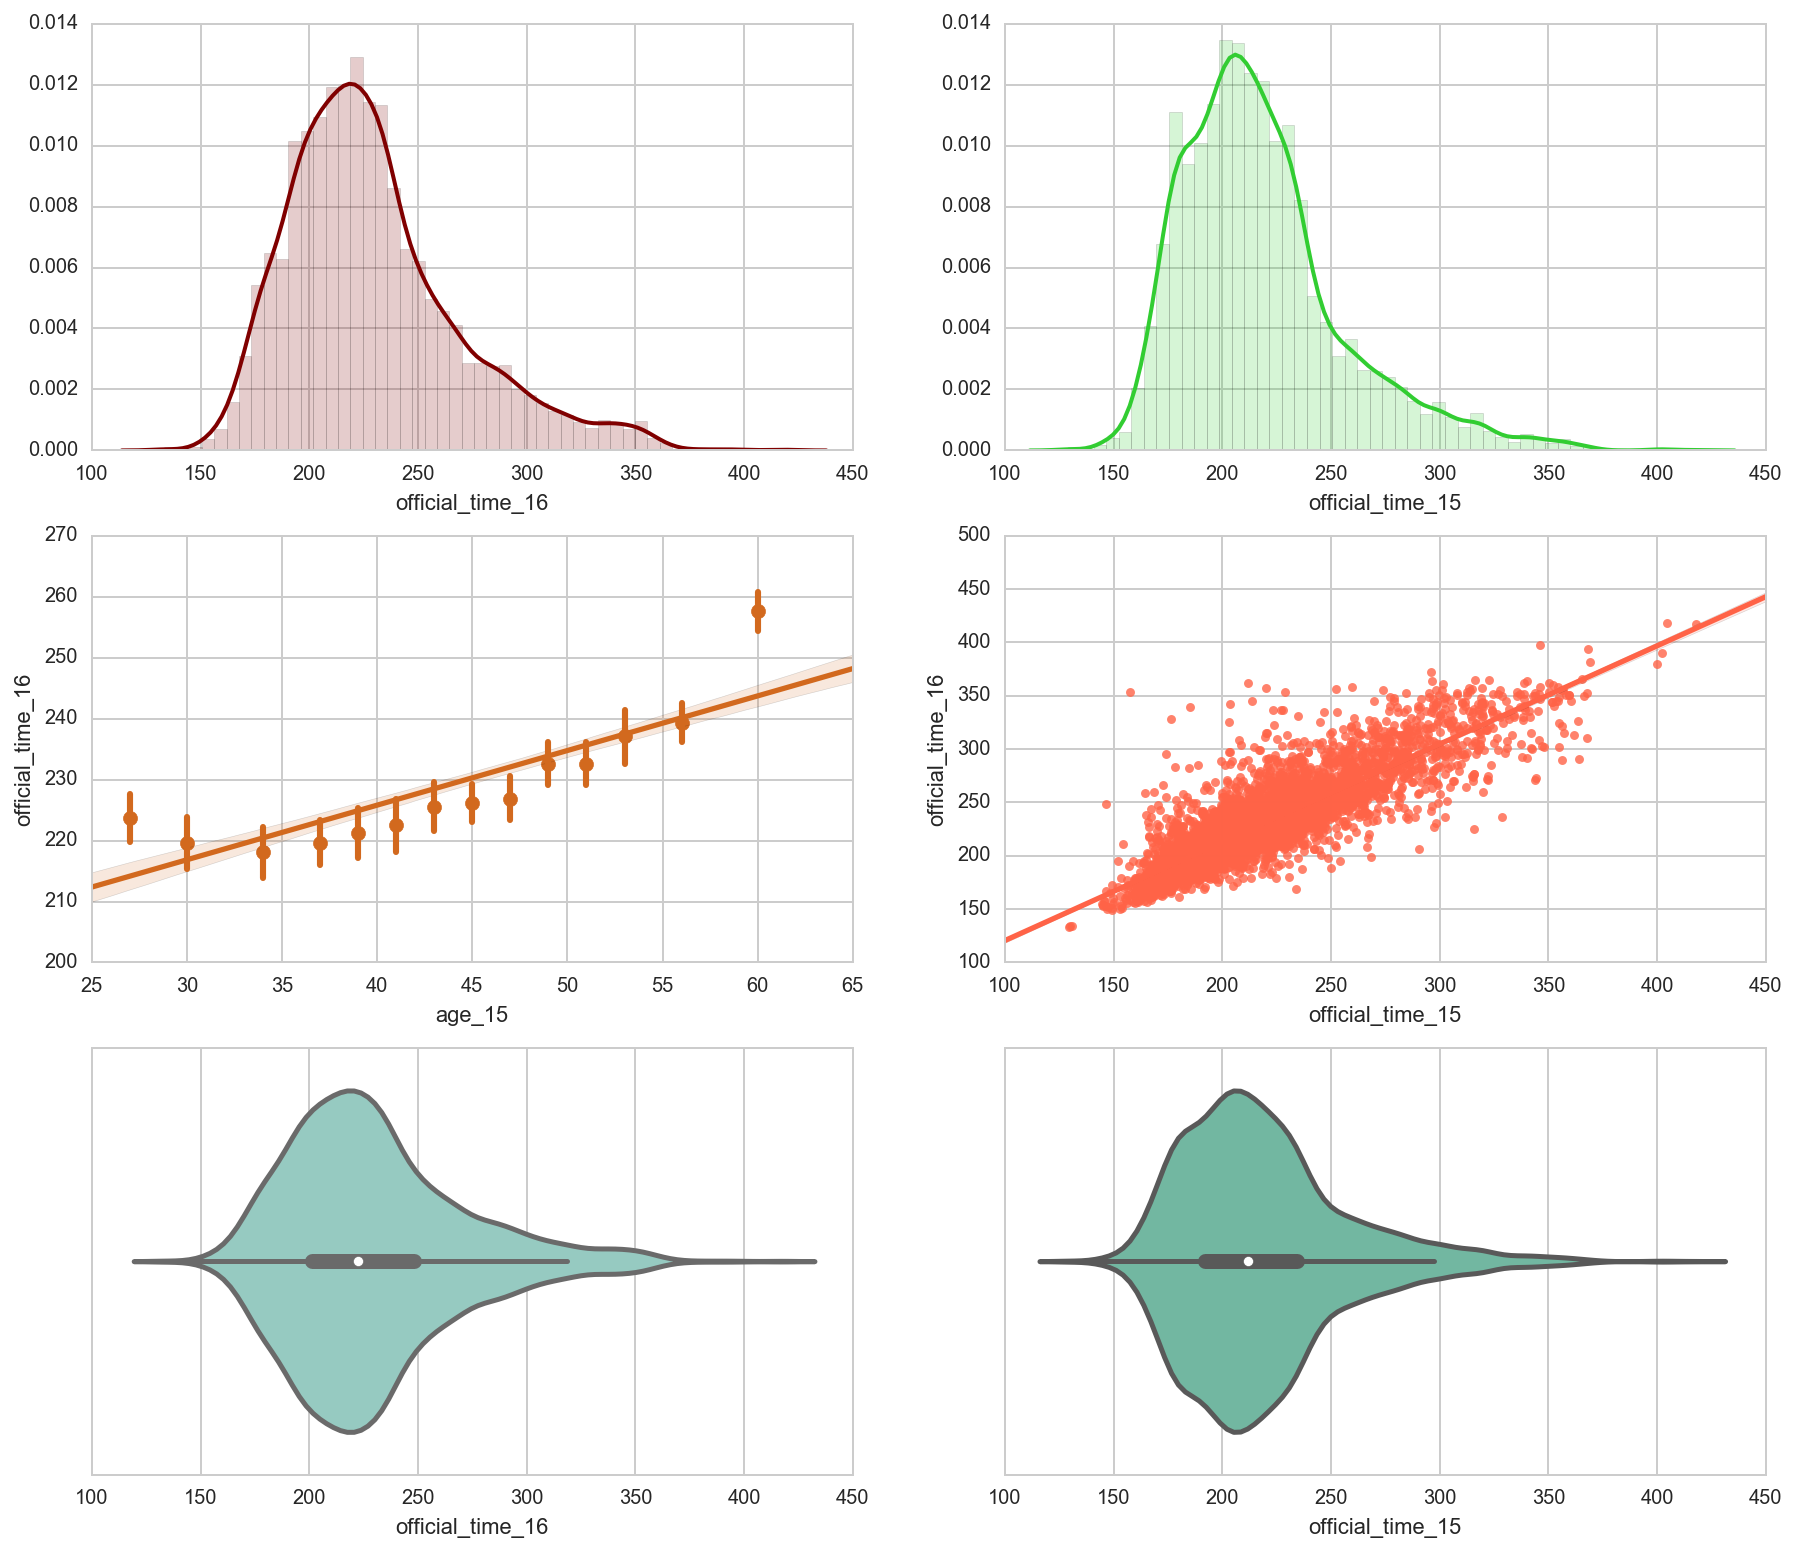

In [7]:
fig, axarr = plt.subplots(3, 2, figsize=(15,13), sharex=False, sharey=False)


axarr[0,0] = sns.distplot(boston_16_15.official_time_16, ax=axarr[0,0], color='maroon', 
                          hist_kws={'alpha':0.2}, kde_kws={'linewidth':2})

axarr[0,1] = sns.distplot(boston_16_15.official_time_15 ,ax=axarr[0,1], color='limegreen',
                                hist_kws={'alpha':0.2}, kde_kws={'linewidth':2})
                          

axarr[1,0] = sns.regplot(boston_16_15.age_15, boston_16_15.official_time_16, ax=axarr[1,0], 
                         ci=95, color='chocolate', x_estimator=np.mean, x_bins=14)

axarr[1,1] = sns.regplot(boston_16_15.official_time_15,
                       boston_16_15.official_time_16, ax=axarr[1,1], marker="o", color='tomato')


axarr[2,0] = sns.violinplot(x="official_time_16", data=boston_16_15, 
                         palette="Set3", ax=axarr[2,0], linewidth=2.5) 


axarr[2,1] = sns.violinplot(x="official_time_15", data=boston_16_15, 
                         palette="Set2", ax=axarr[2,1], linewidth=2.5) 

#fig.savefig('../graphs/rank_gender_time.pdf')
plt.show()


### Finishing times 2015 vs 2106 ? Conclusion
- Runners run the 2015 marathon faster then 2016.
- Runners age in 2015 is positvly correlated with 2016 official times
- 2015 official times are a positively correlated with 2016 official times
- Need to take a closer look now at countries

<a name="predictions"></a>
## Prediction
---
- Using the 2015 finishing times elevations, accumulated meters run, country of residence, gender, age in 2015
I will try to predict the 2016 finishing times

---

In [8]:
## Dummies for countries and gender
'''gender'''
dummies_gen = pd.get_dummies(boston_16_15['gender']).rename(columns=lambda x: 'gender_' + str(x))
boston_16_15 = pd.concat([boston_16_15, dummies_gen], axis=1)

'''countries'''
dummies_ct = pd.get_dummies(boston_16_15['country_res']).rename(columns=lambda x: 'country_res_' + str(x))
boston_16_15 = pd.concat([boston_16_15, dummies_ct], axis=1)

'''dropping originals'''
boston_16_15.drop(['gender', 'country_res'], inplace=True, axis=1)

In [9]:
print boston_16_15.shape

(5438, 90)


In [10]:
''' Notice that from the previous heatmap, there are various variables that are capturing runners performance in 
    2016 therefore are highly correlated with the official 2016 time. Therefore I am goint to exclude them
    I then create a correlation matrix of these futures'''

exclude_cols  =  ['official_time_16', 'age_16', '5_k', '10_k', '15_k', '20_k', 'half', '25_k', '30_k', '35_k', '40_k', 'pace_16',
                  'proj_time_16', 'official_time_16', 'last_name','first_names', 'split_ratio_16' ]

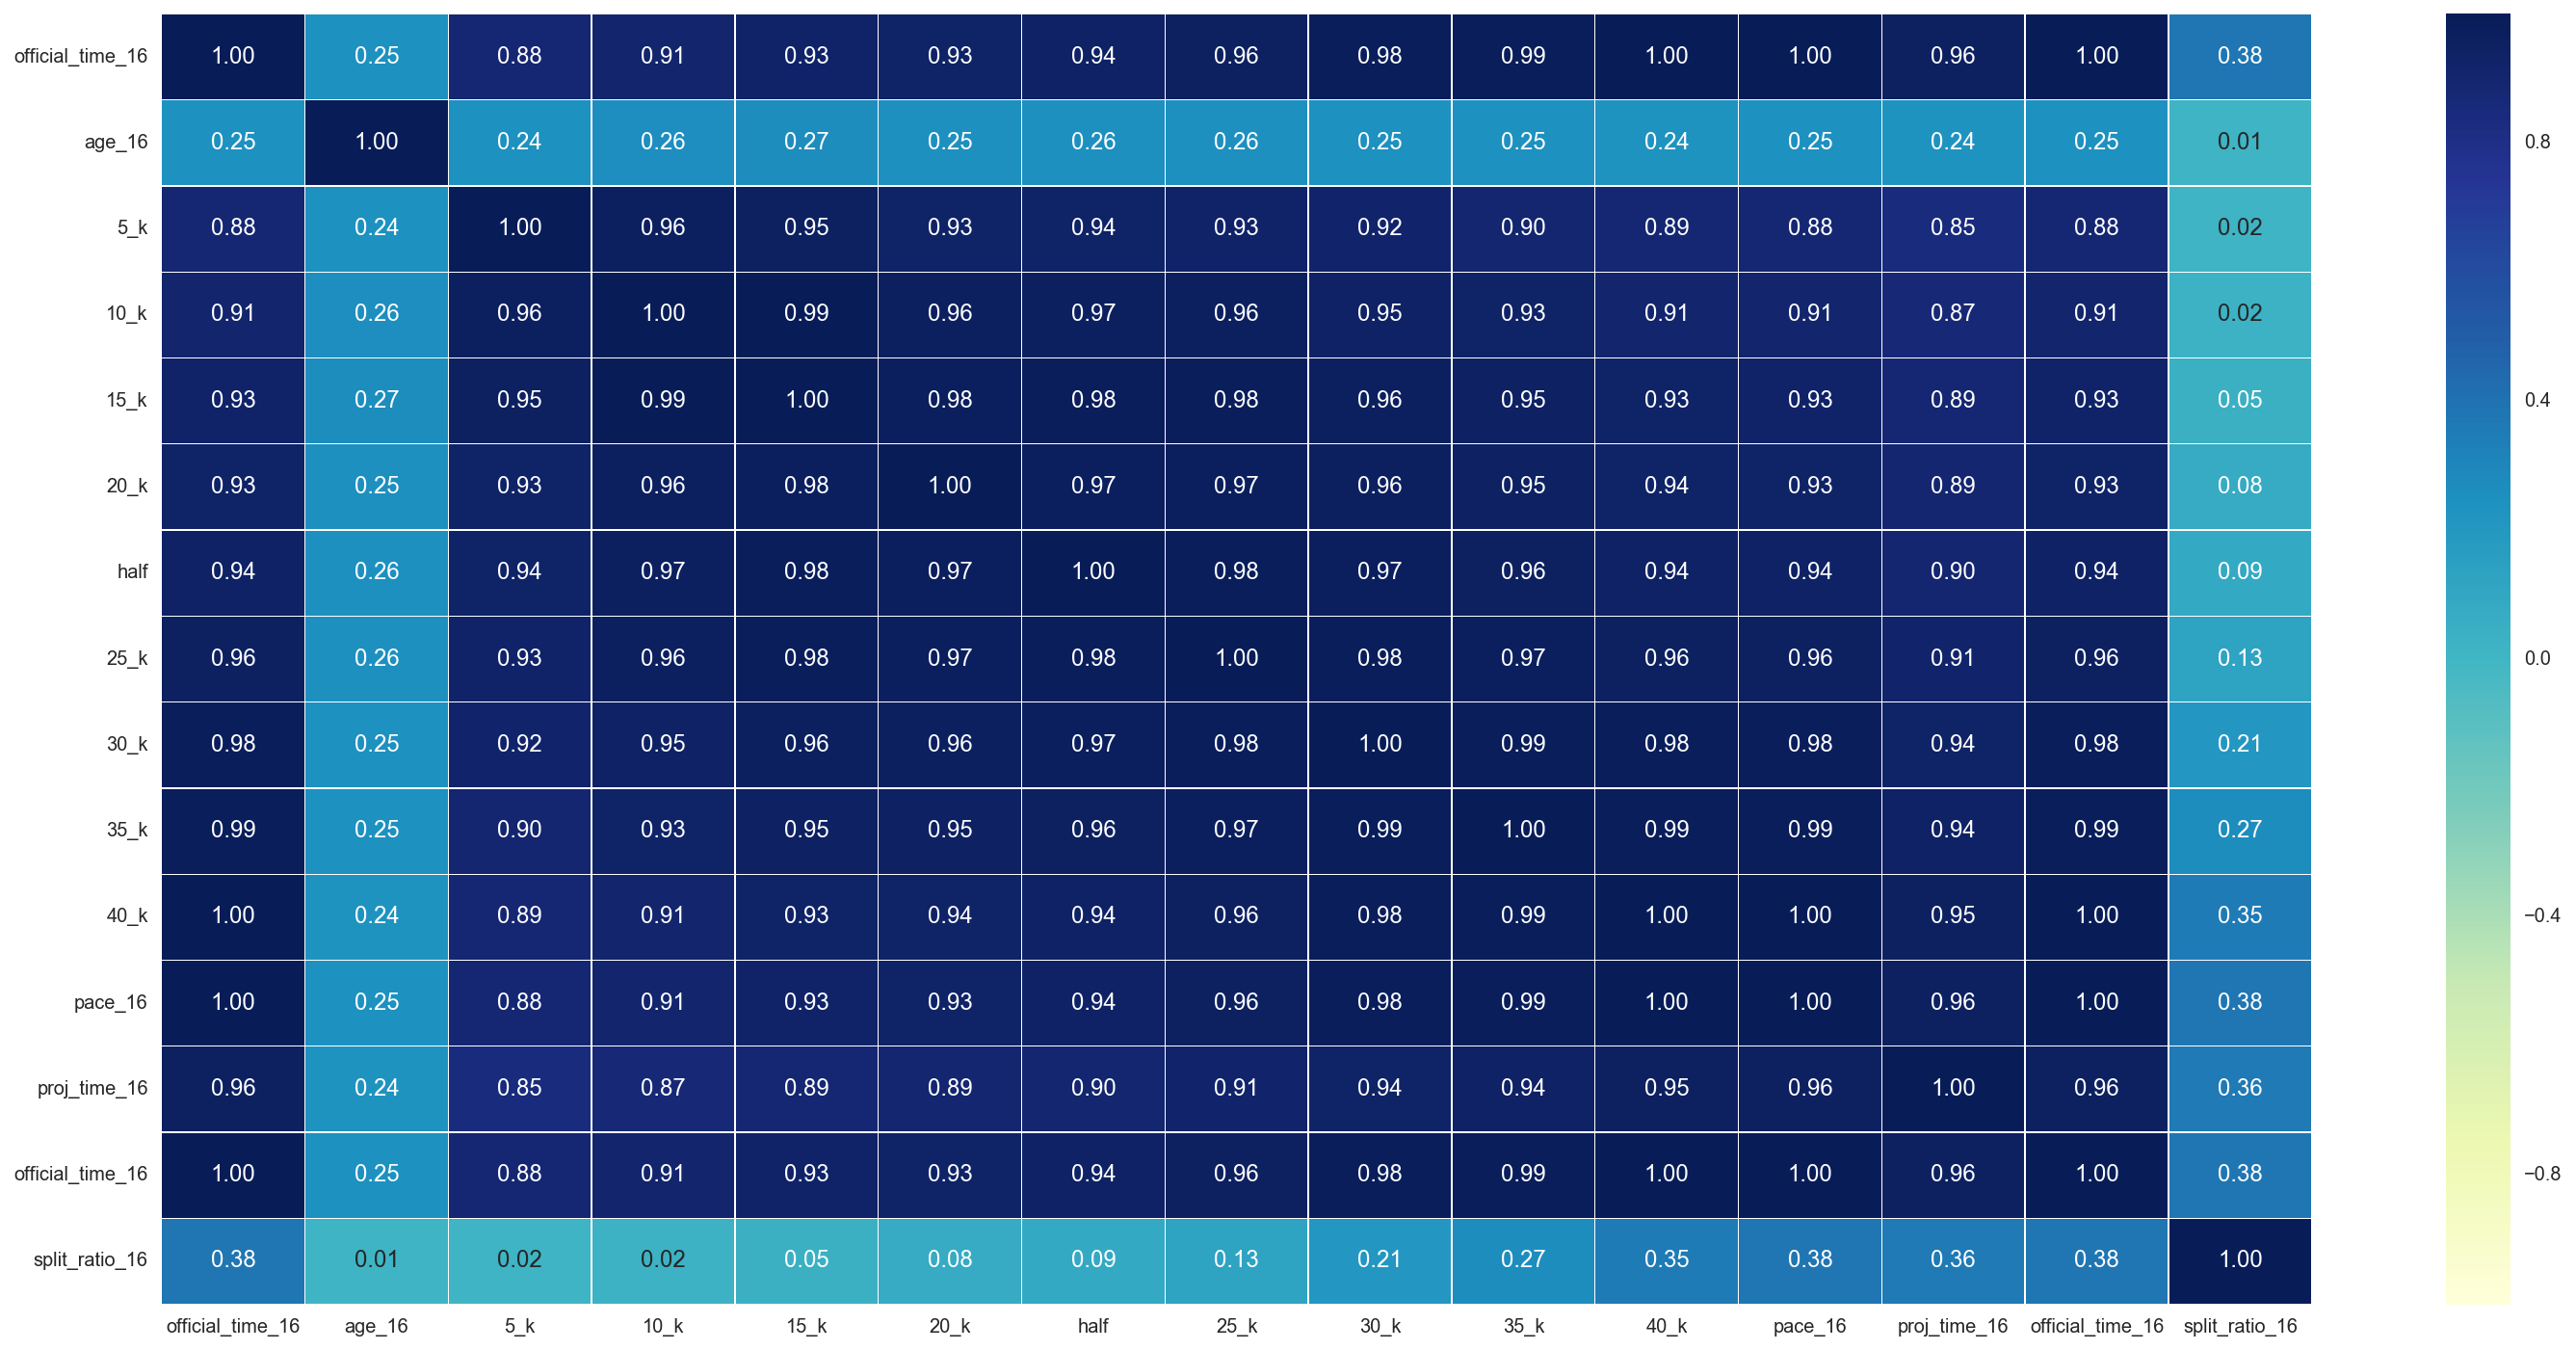

In [11]:
fig = plt.figure(figsize=(25,12))
ax = fig.gca()
sns.heatmap(boston_16_15[exclude_cols].corr(), annot=True, linewidths=.20, 
            annot_kws={'size': 12}, cmap="YlGnBu", vmin=-1, vmax=1, fmt='.2f',ax=ax)
plt.show()

In [12]:
'''Defining predictors and predicted'''
y = boston_16_15.official_time_16.values
col_list = boston_16_15.columns.tolist()
X = boston_16_15[[i for i in col_list if i not in exclude_cols ]]
print y.shape, X.shape


(5438,) (5438, 74)


In [13]:
'''Standarizing the data'''
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
Xn = ss.fit_transform(X)
Xn.shape

(5438, 74)

In [14]:
'''Creating the train and test datasets'''
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3, random_state=10)
print 'Shape of X_train is: ', X_train.shape
print 'Shape of y_train is: ', y_train.shape 
print "\n======\n"
print 'Shape of X_test is: ', X_test.shape
print 'Shape of y_test is: ', y_test.shape

Shape of X_train is:  (3806, 74)
Shape of y_train is:  (3806,)


Shape of X_test is:  (1632, 74)
Shape of y_test is:  (1632,)


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a name="OLS"></a>
## OLS
    
---

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
lm = LinearRegression()

model = lm.fit(X_train, y_train)

linreg_scores = cross_val_score(lm, X_train, y_train, cv=10)

print 'Cross validated R^2 OLS scores:', linreg_scores
print '\n====\n'
print "Average Cross validated R^2 OLS score: %.3f" % (np.mean(linreg_scores))


//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Cross validated R^2 OLS scores: [ -7.36464855e+24  -1.52474545e+24  -6.73806872e+23  -1.10441600e+27
  -3.84133825e+25   6.86880401e-01  -2.71657626e+25  -1.16675257e+25
   7.14308526e-01  -7.77048328e+25]

====

Average Cross validated R^2 OLS score: -126893070448762481469816832.000


In [16]:
''' Function'''
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def rsquare_meansquare_error(train_y, test_y, train_X, test_X, test, best_model):
    print ('Performance of ' + test + ' Regression:\n')
   
    y_train_pred = best_model.predict(train_X)
    y_test_pred = best_model.predict(test_X)
    
    
    print ('MSE ' + test + ' train data: %.2f, test data: %.2f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
    
  
    print('R^2 ' + test + ' train data: %.2f, test data: %.2f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

In [17]:
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "OLS", lm)

Performance of OLS Regression:

MSE OLS train data: 404.11, test data: 21481061378102438312588345344.00
R^2 OLS train data: 0.75, test data: -13715155129136170470998016.00


### Conclusion
- Ols performs poorly, negative R^2 and MSE values on test set is not right

<a name="ridge"></a>
## Regularization Methods - Ridge
    
---

In [18]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

ridge_alphas = np.logspace(0, 5, 100)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)
print 'Optimal Ridge alpha:' ,optimal_ridge.alpha_
print '\n====\n'

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge.fit(X_train, y_train)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print 'Cross validated R^2 Ridge scores:', ridge_scores
print '\n====\n'
print "Average Cross validated R^2 Ridge score: %.3f" % (np.mean(ridge_scores))

Optimal Ridge alpha: 14.508287785

====

Cross validated R^2 Ridge scores: [ 0.76584403  0.76342404  0.70580614  0.68243529  0.80395288  0.68777555
  0.74999887  0.76419736  0.71737143  0.76959098]

====

Average Cross validated R^2 Ridge score: 0.741


In [19]:
## Ridge Regression Performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Ridge", ridge)

Performance of Ridge Regression:

MSE Ridge train data: 404.08, test data: 397.78
R^2 Ridge train data: 0.75, test data: 0.75


<a name="lasso"></a>
## Regularization Methods - Lasso
    
---


In [20]:
optimal_lasso = LassoCV(n_alphas=300, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)
print 'Optimal Lasso alpha:', optimal_lasso.alpha_
print '\n====\n'

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train, y_train)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)


print 'Cross validated R^2 Lasso scores:', lasso_scores
print '\n====\n'
print "Average Cross validated R^2 Lasso score: %.3f" % (np.mean(lasso_scores))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal Lasso alpha: 0.257419463514

====

Cross validated R^2 Lasso scores: [ 0.76442546  0.76387193  0.70656478  0.68313324  0.80434962  0.68958878
  0.75077515  0.76342989  0.71940341  0.77267196]

====

Average Cross validated R^2 Lasso score: 0.742


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
# Lasso Regression performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Lasso", lasso)

Performance of Lasso Regression:

MSE Lasso train data: 405.45, test data: 395.75
R^2 Lasso train data: 0.75, test data: 0.75


<a name="elasticnet"></a>
## Regularization Methods - Elastic Net
---

In [22]:
l1_ratios = np.linspace(0.01, 1.0, 50)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5, verbose=1)
optimal_enet.fit(X_train, y_train)
print optimal_enet.alpha_
print '\n====\n'
print optimal_enet.l1_ratio_

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet.fit(X_train, y_train)


enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

print 'Cross validated R^2 Elastic Net scores:', enet_scores
print '\n====\n'
print "Average cross validates R^2 ElasticNet score: %.3f" % (np.mean(enet_scores))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.257419463514

====

1.0
Cross validated R^2 Elastic Net scores: [ 0.76442546  0.76387193  0.70656478  0.68313324  0.80434962  0.68958878
  0.75077515  0.76342989  0.71940341  0.77267196]

====

Average cross validates R^2 ElasticNet score: 0.742


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   10.5s finished


In [23]:
## Elastic Net Regression Performance 
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Enet", enet)

Performance of Enet Regression:

MSE Enet train data: 405.45, test data: 395.75
R^2 Enet train data: 0.75, test data: 0.75


In [24]:
''' Function to print the coefficients, their absolute values and the non-absolute values'''
def best_reg_method(X, best_regulari):
    method_coefs = pd.DataFrame({'variable':X.columns, 
                                 'coef':best_regulari.coef_, 
                                 'abs_coef':np.abs(best_regulari.coef_)})
    method_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    return method_coefs.head(20)

In [25]:
'''Here I am using Lasso'''
best_reg_method(X, lasso)

,abs_coef,coef,variable
31,34.126004,34.126004,official_time_15
30,0.872827,0.872827,age_15
56,0.763799,0.763799,country_res_ISR
68,0.412318,0.412318,country_res_SUI
38,0.402315,-0.402315,country_res_BRA
71,0.329346,0.329346,country_res_USA
59,0.134530,-0.134530,country_res_JPN
57,0.129466,-0.129466,country_res_ITA
63,0.121863,0.121863,country_res_NED
43,0.087045,-0.087045,country_res_CRC


In [26]:
# residuals on training:
ols_resd_train  = y_train - lm.predict(X_train)
ridge_resd_train = y_train - ridge.predict(X_train)
lasso_resd_train = y_train - lasso.predict(X_train)
enet_resd_train = y_train - enet.predict(X_train)

# residuals on test:
ols_resd_test  = y_test - lm.predict(X_test)
ridge_resd_test = y_test - ridge.predict(X_test)
lasso_resd_test = y_test - lasso.predict(X_test)
enet_resd_test = y_test - enet.predict(X_test)

In [27]:
def plotter_graph(OLS_resd, Ridge_resd, Lasso_resd, Enet_resd):
    fig, axarr = plt.subplots(1, 4, figsize=(18, 6))
    sns.distplot(OLS_resd, bins=50, hist=True, kde=False, 
             color='steelblue', ax=axarr[0], label='OLS residuals')
    sns.distplot(Ridge_resd, bins=50, hist=True, kde=False, 
             color='darkred', ax=axarr[1], label='Ridge residuals')
    sns.distplot(Lasso_resd, bins=50, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[2], label='Lasso residuals')
    sns.distplot(Enet_resd, bins=50, hist=True, kde=False, 
             color='g', ax=axarr[3], label='ElasticNet residuals')
    plt.legend(loc='best')
    plt.show()

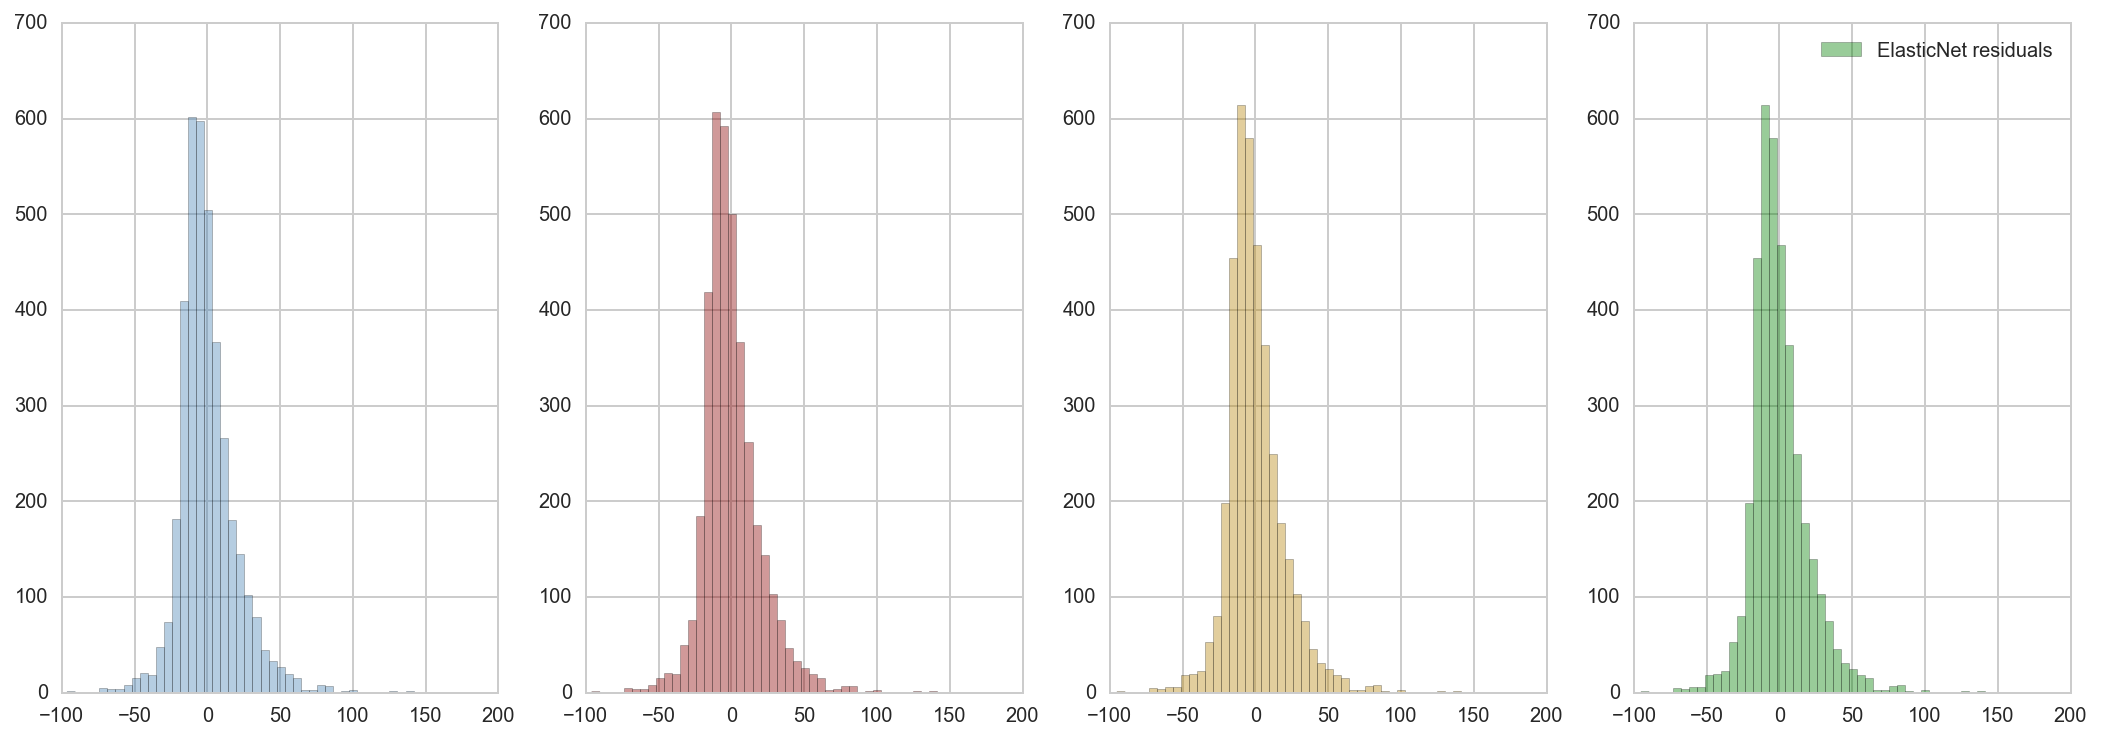

In [28]:
plotter_graph(ols_resd_train, ridge_resd_train, lasso_resd_train, enet_resd_train)

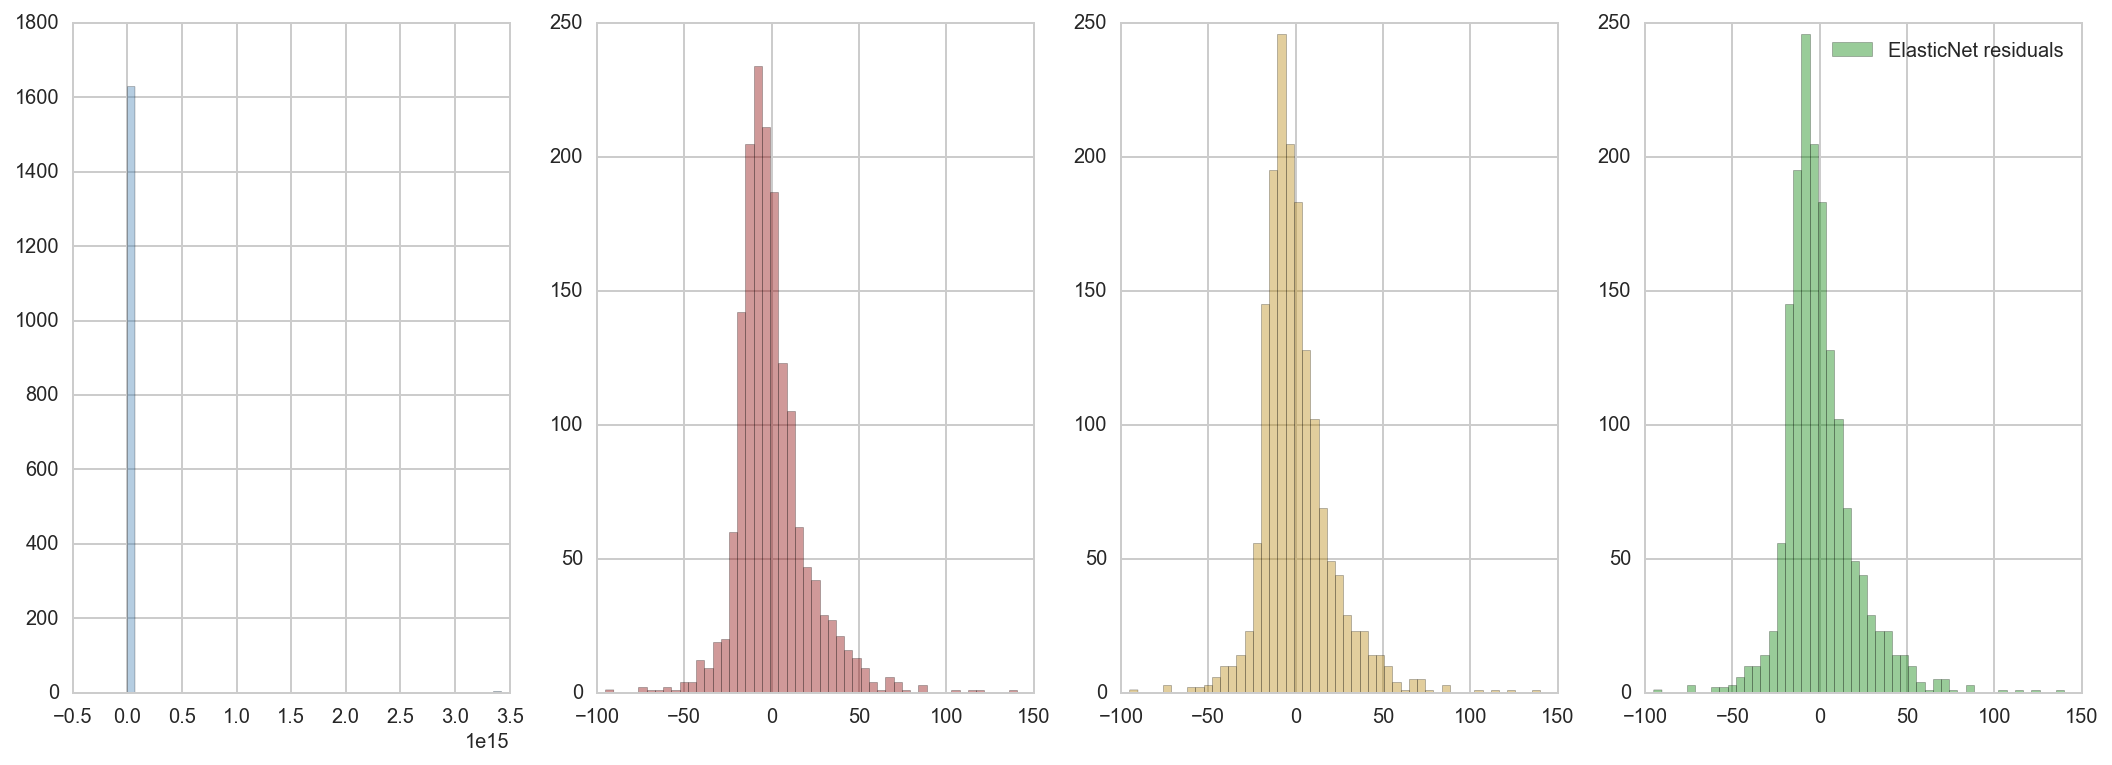

In [29]:
plotter_graph(ols_resd_test, ridge_resd_test, lasso_resd_test, enet_resd_test)

### Conclusion
- Of the 3 regularization methods Lasso and Elastic Net have the best performance: R^2 is consistent in train and test, and MSE is lower in test data. I feel fine choosing either one of them for now (I choose Lasso)
- Also, the distribution of residuals is consistent. They are normally distribution in train and test, for Lasso and Elastic Net.
- The features that have greater predictive explanatory power of the 2016 official finishing times, (age in 2015, official time in 2015, and residing in countries like Israel, Sweeterland, Brazil, USA, Japan.
- Oddly enough residing in Ethiopia doesn't have any explanatory power. Perhaps they train in different nations (i.e. USA, ITA, NED, ISR)

- Ok, but I might be overfitting, lets take a look at other models:


<a name="regressiontree"></a>
## Regression Tree 
---   


In [30]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
params = {"max_depth": [3,5,10,20],
          "max_features": [None, "auto"],
          "min_samples_leaf": [1, 3, 5, 7, 10],
          "min_samples_split": [2, 5, 7],
           "criterion" : ['mse']
         }
from sklearn.grid_search import GridSearchCV
dtr_gs = GridSearchCV(dtr, params, n_jobs=-1, cv=5, verbose=1)

//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [31]:
dtr_gs.fit(X_train, y_train)

''' dtr_best = is the regression tree regressor with best parameters/estimators'''
dtr_best = dtr_gs.best_estimator_ 

print "best estimator", dtr_best
print "\n==========\n"
print "best parameters",  dtr_gs.best_params_
print "\n==========\n"
print "best score", dtr_gs.best_score_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s


best estimator DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


best parameters {'max_features': None, 'min_samples_split': 2, 'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 10}


best score 0.732613967656


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished


In [32]:
## Regression Tree Performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Regression tree", dtr_best)

Performance of Regression tree Regression:

MSE Regression tree train data: 389.04, test data: 415.26
R^2 Regression tree train data: 0.76, test data: 0.73


In [33]:
''' Function to print feature importance using best models'''
def feature_importance(X, best_model):
    feature_importance = pd.DataFrame({'feature':X.columns, 'importance':best_model.feature_importances_})
    feature_importance.sort_values('importance', ascending=False, inplace=True)
    return feature_importance.head(20)

In [34]:
feature_importance(X, dtr_best)

,feature,importance
31,official_time_15,0.991981
30,age_15,0.006813
33,gender_M,0.000660
32,gender_F,0.000546
46,country_res_ESP,0.000000
52,country_res_GUA,0.000000
51,country_res_GER,0.000000
50,country_res_GBR,0.000000
49,country_res_FRA,0.000000
48,country_res_FIN,0.000000


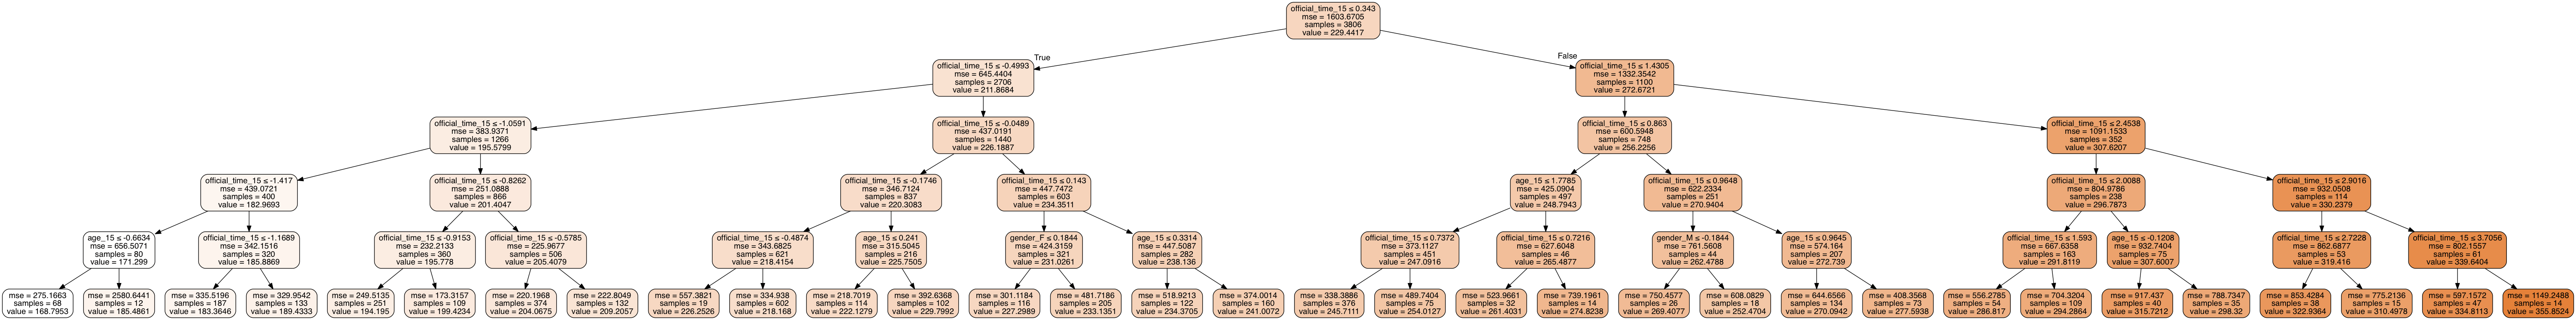

In [35]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pydot

dot_data = StringIO()
''' dtr_best was previously defined'''
export_graphviz(dtr_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<a name="randomforest"></a>
## Random Forest Regression Tree
---

In [36]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor( )

params = {'max_depth':[3,4,5],  
          'max_leaf_nodes':[5,6,7], 
          'min_samples_split':[3,4],
          'n_estimators': [100]
         }

estimator_rfr = GridSearchCV(forest, params, n_jobs=-1,  cv=5,verbose=1)

In [37]:
estimator_rfr.fit(X_train, y_train)
''' rfr_best = is the random forest regression tree regressor with best parameters/estimators'''
rfr_best = estimator_rfr.best_estimator_
print "best estimator", rfr_best
print "\n==========\n"
print "best parameters", estimator_rfr.best_params_
print "\n==========\n"
print "best score", estimator_rfr.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.3s finished


best estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=7, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


best parameters {'min_samples_split': 4, 'max_leaf_nodes': 7, 'n_estimators': 100, 'max_depth': 5}


best score 0.734199726442


In [38]:
## Random Forest Regression Tree Performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Random Forest Regression tree", rfr_best)

Performance of Random Forest Regression tree Regression:

MSE Random Forest Regression tree train data: 410.23, test data: 407.98
R^2 Random Forest Regression tree train data: 0.74, test data: 0.74


In [39]:
## Feauture importance
feature_importance(X, rfr_best)

,feature,importance
31,official_time_15,1.0
0,elev_5k_meter,0.0
47,country_res_ETH,0.0
53,country_res_HKG,0.0
52,country_res_GUA,0.0
51,country_res_GER,0.0
50,country_res_GBR,0.0
49,country_res_FRA,0.0
48,country_res_FIN,0.0
46,country_res_ESP,0.0


<a name="gradientboosting"></a>
## Gradient Boosting Regressor
--- 

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
grad_est = GradientBoostingRegressor()

params = {"max_depth": [3,5,10,20],
          "max_features": [None, "auto"],
          "min_samples_leaf": [1, 3, 5, 7, 10],
          "min_samples_split": [2, 5, 7],
          'n_estimators': np.arange(100,200,10)
         }
estimator_gbr = GridSearchCV(grad_est, params, n_jobs=-1, cv=5,verbose=1)

In [41]:
estimator_gbr.fit(X_train, y_train)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 27.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'auto'], 'min_samples_split': [2, 5, 7], 'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190]), 'max_depth': [3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [42]:
''' gbr_best = is the GradientBoostingRegressor with best parameters/estimators'''
gbr_best = estimator_gbr.best_estimator_ 

print "best estimator", gbr_best
print "\n==========\n"
print "best parameters",  estimator_gbr.best_params_
print "\n==========\n"
print "best score", estimator_gbr.best_score_

best estimator GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=7,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


best parameters {'max_features': None, 'min_samples_split': 7, 'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}


best score 0.740219773728


In [43]:
## Gradient Boosting Regressor Performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Gradient Boosting Regressor", gbr_best)

Performance of Gradient Boosting Regressor Regression:

MSE Gradient Boosting Regressor train data: 363.80, test data: 402.77
R^2 Gradient Boosting Regressor train data: 0.77, test data: 0.74


In [44]:
## Feauture importance
feature_importance(X, gbr_best)

,feature,importance
31,official_time_15,0.741248
30,age_15,0.149342
32,gender_F,0.026117
71,country_res_USA,0.019011
38,country_res_BRA,0.014732
42,country_res_COL,0.010326
59,country_res_JPN,0.010170
33,gender_M,0.008950
41,country_res_CHN,0.006973
57,country_res_ITA,0.005989


<a name="ensemblegradient"></a>
## Ensemble Gradient Boosting Regressor
---

In [45]:
from sklearn import ensemble
from sklearn.utils import shuffle

params = {'max_features': None, 
          'max_depth': 20, 
          'min_samples_split': 2, 
          'min_samples_leaf': 1,
          'n_estimators': 120, 
          'loss': 'ls', 
          'alpha':0.9, 
          'subsample':1.0, 
          'learning_rate':0.1}

ensem_grad_est = ensemble.GradientBoostingRegressor(**params)

ensem_grad_est.fit(X_train, y_train)
''' ensem_grad_best = is the Ensemble GradientBoostingRegressor with best parameters/estimators'''
ensem_grad_best = ensem_grad_est 

In [46]:
# ## Ensemble Gradient Boosting Regressor Performance
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Ensemble Gradient Boosting Regressor", ensem_grad_best)

Performance of Ensemble Gradient Boosting Regressor Regression:

MSE Ensemble Gradient Boosting Regressor train data: 0.85, test data: 839.60
R^2 Ensemble Gradient Boosting Regressor train data: 1.00, test data: 0.46


In [47]:
## Feauture importance
feature_importance(X, ensem_grad_best)

,feature,importance
31,official_time_15,0.730859
30,age_15,0.212314
33,gender_M,0.018507
32,gender_F,0.015881
71,country_res_USA,0.009232
39,country_res_CAN,0.007872
62,country_res_MEX,0.000565
38,country_res_BRA,0.000557
59,country_res_JPN,0.000476
35,country_res_AUS,0.000459


<a name="modelperformance"></a>
## Summary of Model's Performance  MSE and R^2
---

In [48]:
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "OLS", lm)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Lasso", lasso)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Ridge", ridge)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Elastic Net", enet)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Regression tree", dtr_best)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Random Forest Regression tree", rfr_best)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Gradient Boosting Regressor", gbr_best)
print '\n=====\n'
rsquare_meansquare_error(y_train, y_test, X_train, X_test, "Ensemble Gradient Boosting Regressor", ensem_grad_best)


Performance of OLS Regression:

MSE OLS train data: 404.11, test data: 21481061378102438312588345344.00
R^2 OLS train data: 0.75, test data: -13715155129136170470998016.00

=====

Performance of Lasso Regression:

MSE Lasso train data: 405.45, test data: 395.75
R^2 Lasso train data: 0.75, test data: 0.75

=====

Performance of Ridge Regression:

MSE Ridge train data: 404.08, test data: 397.78
R^2 Ridge train data: 0.75, test data: 0.75

=====

Performance of Elastic Net Regression:

MSE Elastic Net train data: 405.45, test data: 395.75
R^2 Elastic Net train data: 0.75, test data: 0.75

=====

Performance of Regression tree Regression:

MSE Regression tree train data: 389.04, test data: 415.26
R^2 Regression tree train data: 0.76, test data: 0.73

=====

Performance of Random Forest Regression tree Regression:

MSE Random Forest Regression tree train data: 410.23, test data: 407.98
R^2 Random Forest Regression tree train data: 0.74, test data: 0.74

=====

Performance of Gradient Boosti

<a name="predictedvsactual"></a>
## Predicted vs real values (all models)
---

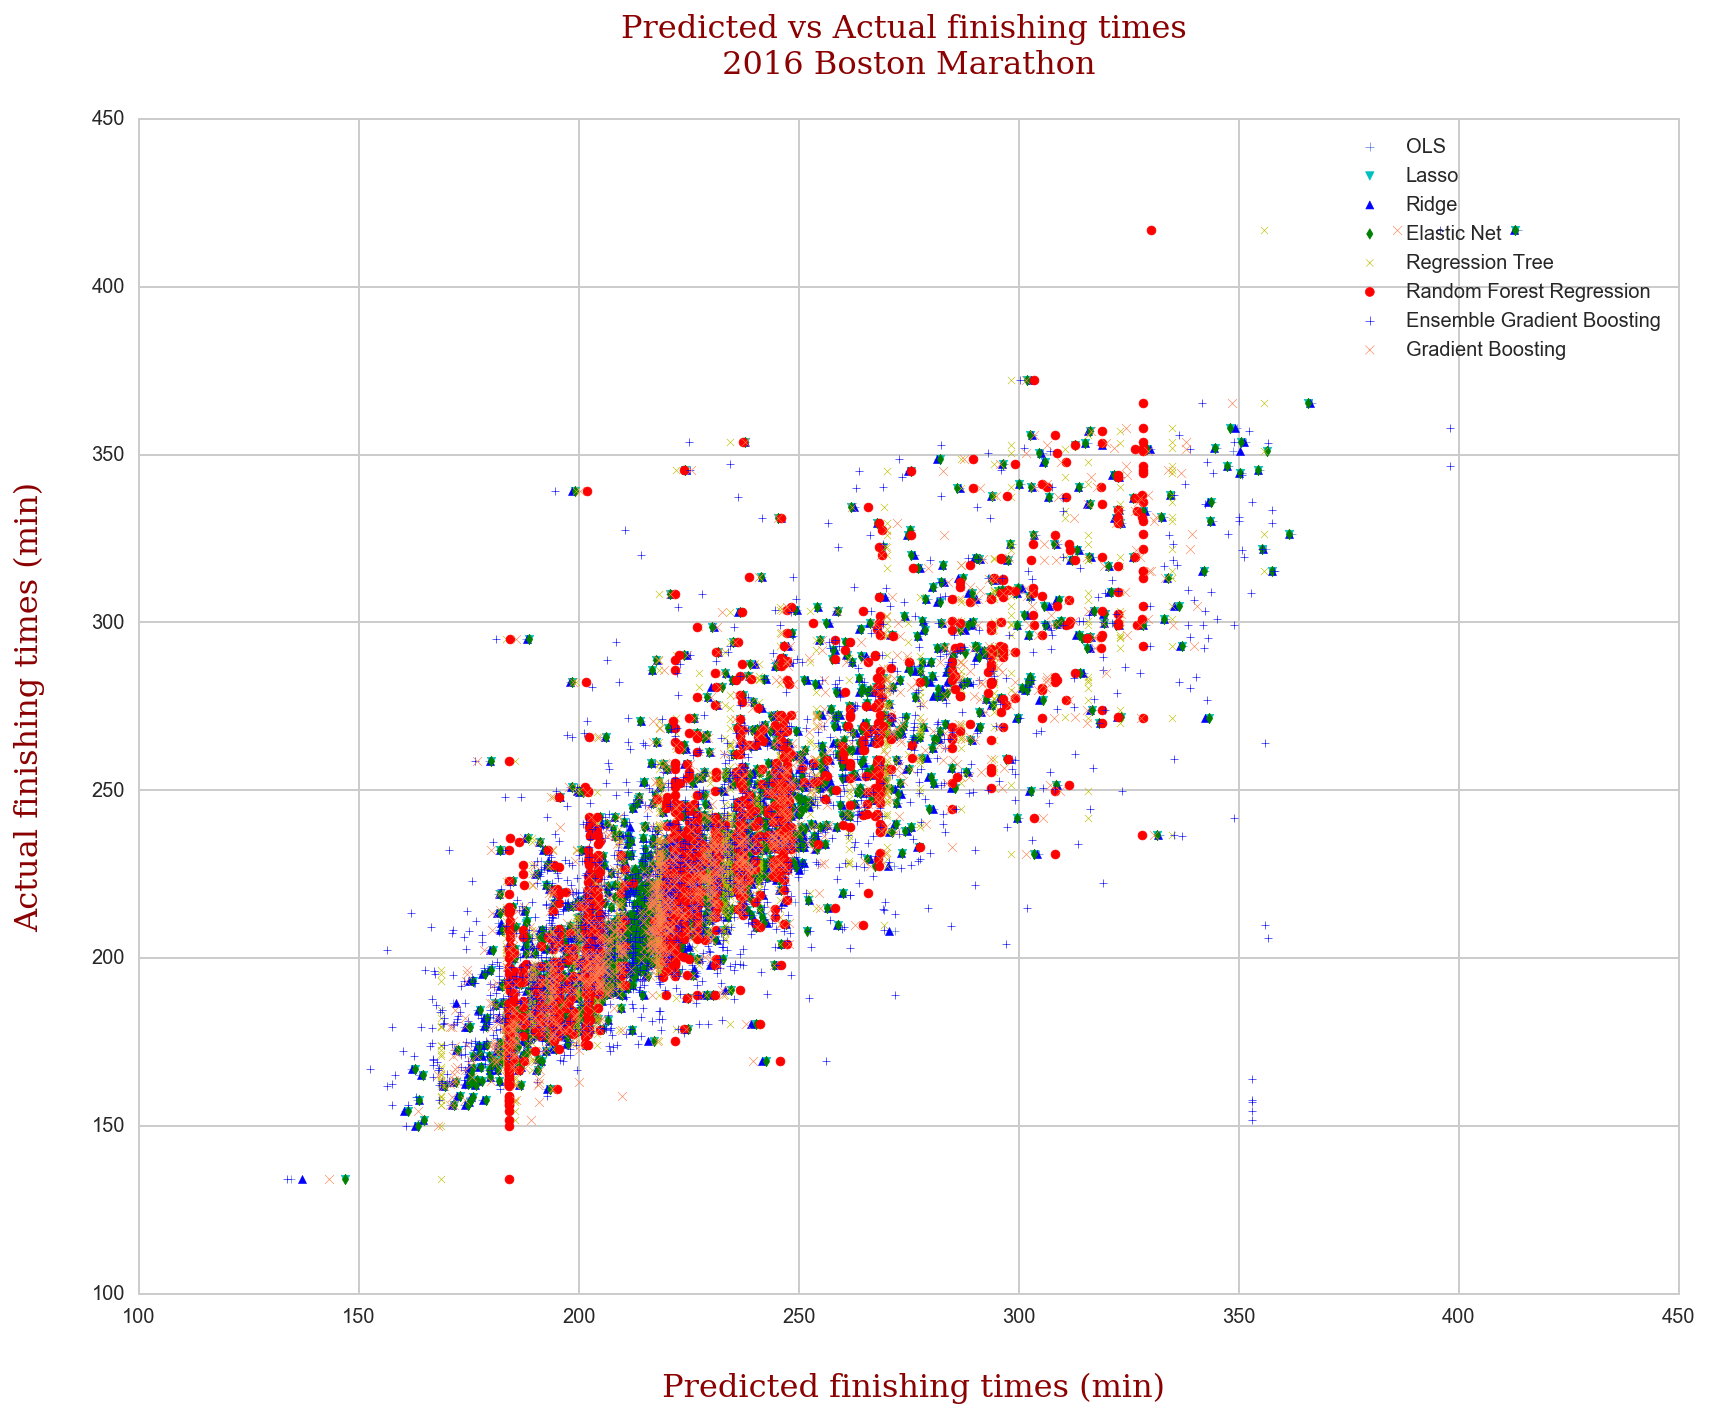

In [49]:
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(12,10))
    plt.scatter(lm.predict(X_test), y_test, s=20, c='royalblue', marker='+', label="OLS")
    plt.scatter(lasso.predict(X_test), y_test, color='c', s=18, marker='v', label='Lasso')
    plt.scatter(ridge.predict(X_test), y_test, color='b', s=16, marker="^", label='Ridge')
    plt.scatter(enet.predict(X_test), y_test, color='g', s=14, marker="d", label='Elastic Net')
    plt.scatter(dtr_gs.predict(X_test), y_test, color='y', s=13, marker="x", label='Regression Tree' )
    plt.scatter(estimator_rfr.predict(X_test), y_test, color='r', marker='o', label='Random Forest Regression')
    plt.scatter(ensem_grad_est.predict(X_test), y_test, color='b', marker='+', label='Ensemble Gradient Boosting')
    plt.scatter(estimator_gbr.predict(X_test), y_test, color='coral', marker='x', label='Gradient Boosting')
    
    plt.title('Predicted vs Actual finishing times \n 2016 Boston Marathon \n',fontdict=font)
    plt.xlabel("\n Predicted finishing times (min)", fontdict=font)
    plt.ylabel("Actual finishing times (min)\n", fontdict=font)
    plt.legend(loc='best')
    plt.xlim([100, 450])
    plt.tight_layout()
    plt.show()

### Conclusion
---
- When looking at the MSE and R^2 values on ranking their MSE and R^2 performance on the test data, the following models have the best performance:
    - Lasso (MSE=395.75, R^2=0.75)
    - Elastic Net (MSE=395.75, R^2=0.75)
    - Gradient Boosting Regressor Regression (MSE = 402.77, R^2 =0.74)
    - Random Forest Regression Tree Regression (MSE= 407.98 R^2 = 0.74) 
    

- On the other hand, the model(s) that are more consistent in train and test data are:
    - Random Forest Regression Tree Regression (MSE on train =410.23, R^2 on train =0.74; MSE on test = 407.98, R^2 on test =0.74). However, this model is overfitting